In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
import xgboost as xgb

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


import time


In [18]:
center = pd.read_csv("fulfilment_center.csv")
meal = pd.read_csv("meal_info.csv")
train = pd.read_csv("trainFood.csv")
test = pd.read_csv("test.csv")

In [20]:
# Join the DataFrames on 'meal_id'
df = pd.merge(center, train, on='center_id', how='inner')
df_train = pd.merge(df, meal, on='meal_id', how='inner')
df_train.head()

# Generate the weekly date range starting from January 1, 2018, for 145 weeks
start_date = '2018-01-01'
periods = 145  # Total number of weeks
frequency = 'W'  # Weekly frequency
date_series = pd.date_range(start=start_date, periods=periods, freq=frequency)

# Create a mapping from week numbers to dates
week_to_date_map = {week: date for week, date in zip(range(1, 146), date_series)}

# Map the 'week' column to dates using the map created
df_train['Date'] = df_train['week'].map(week_to_date_map)

df_train['month'] = df_train['Date'].dt.month
df_train['year'] = df_train['Date'].dt.year
df_train.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,Date,month,year
0,11,679,56,TYPE_A,3.7,1103215,1,1885,136.83,136.83,0,0,959,Beverages,Thai,2018-01-07,1,2018
1,11,679,56,TYPE_A,3.7,1093939,1,1993,133.89,133.89,0,0,1052,Beverages,Thai,2018-01-07,1,2018
2,11,679,56,TYPE_A,3.7,1120771,1,2539,133.86,135.86,0,0,379,Beverages,Thai,2018-01-07,1,2018
3,11,679,56,TYPE_A,3.7,1472938,1,2139,339.50,436.53,0,0,54,Beverages,Indian,2018-01-07,1,2018
4,11,679,56,TYPE_A,3.7,1136817,1,2631,251.23,251.23,0,0,80,Beverages,Indian,2018-01-07,1,2018


In [22]:
# Generate the weekly date range starting from January 1, 2018, for 145 weeks
start_date = '2018-01-01'
periods = 145  # Total number of weeks
frequency = 'W'  # Weekly frequency

date_series = pd.date_range(start=start_date, periods=periods, freq=frequency)

# Create a mapping from week numbers to dates
week_to_date_map = {week: date for week, date in zip(range(1, 146), date_series)}

# Map the 'week' column to dates using the map created
df_train['Date'] = df_train['week'].map(week_to_date_map)

df_train['month'] = df_train['Date'].dt.month
df_train['year'] = df_train['Date'].dt.year

df_train.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,Date,month,year
0,11,679,56,TYPE_A,3.7,1103215,1,1885,136.83,136.83,0,0,959,Beverages,Thai,2018-01-07,1,2018
1,11,679,56,TYPE_A,3.7,1093939,1,1993,133.89,133.89,0,0,1052,Beverages,Thai,2018-01-07,1,2018
2,11,679,56,TYPE_A,3.7,1120771,1,2539,133.86,135.86,0,0,379,Beverages,Thai,2018-01-07,1,2018
3,11,679,56,TYPE_A,3.7,1472938,1,2139,339.50,436.53,0,0,54,Beverages,Indian,2018-01-07,1,2018
4,11,679,56,TYPE_A,3.7,1136817,1,2631,251.23,251.23,0,0,80,Beverages,Indian,2018-01-07,1,2018


In [24]:
display(df_train['Date'].max())
display(df_train['Date'].min())

Timestamp('2020-10-11 00:00:00')

Timestamp('2018-01-07 00:00:00')

In [26]:
df_train = df_train.reset_index()

In [28]:
# Remove Oct 2020 from the training set and rerun rolling average
df_train = df_train[~((df_train['year'] == 2020) & (df_train['month'] == 10))]

## Part 1 - Question 1

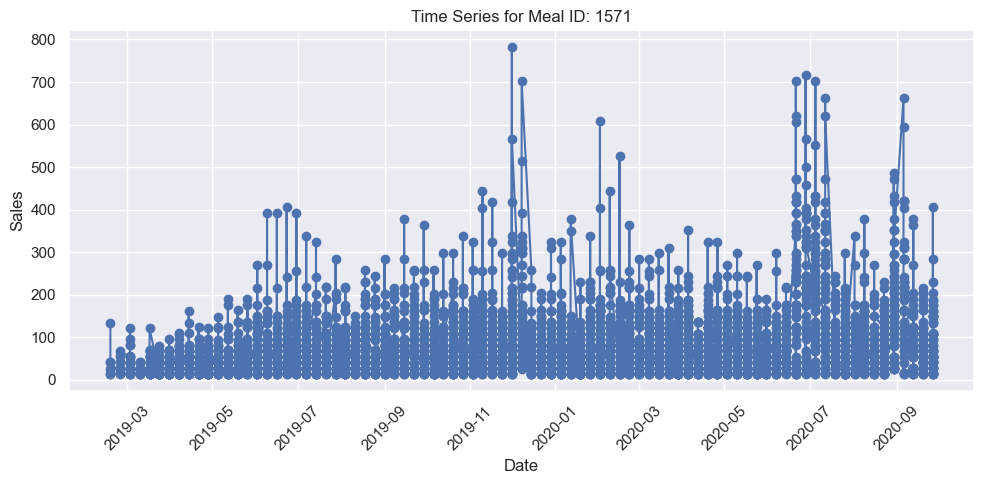

In [38]:
import matplotlib.pyplot as plt

# Sort the data by 'Date' column
df_train = df_train.sort_values('Date')

# Filter the DataFrame for meal_id 1571
meal_id = 1571
temp_df = df_train[df_train['meal_id'] == meal_id]

# Sort the data by date to ensure it plots correctly
temp_df = temp_df.sort_values('Date')

# Plotting
plt.figure(figsize=(10, 5))  # You can adjust the size of the figure
plt.plot(temp_df['Date'], temp_df['num_orders'], marker='o', linestyle='-')  # Line plot with dots at data points
plt.title(f'Time Series for Meal ID: {meal_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated date labels
plt.show()

For this analysis, we selected a **fish product** (meal_id to be chosen based on available data) and plotted its **sales over time** to assess trends, seasonality, and suitability for forecasting. The time series visualization provided key insights into demand patterns—revealing whether the data exhibited **stationarity**, **trends**, **seasonal fluctuations**, or **outliers** that could influence forecasting performance.

In this visualization, we observed **significant spikes in sales**, which correspond to **promotional cycles**. These promotional-driven peaks indicate that demand is not purely driven by organic trends or seasonality but rather by external marketing factors. As we have seen in previous analyses, **traditional ARIMA models** may struggle to capture such behavior effectively because they rely primarily on past values and assume a more stable, autocorrelated structure. Without incorporating **exogenous variables** (such as promotion flags or pricing), ARIMA may not adequately adjust for these demand surges, making it less suitable for this dataset.

If the fish product follows a **consistent trend or seasonality** (e.g., periodic demand fluctuations due to holidays or cyclical patterns), then **SARIMA or exponential smoothing methods** might be appropriate. However, given the **irregular demand shifts** driven by promotions, a more **feature-rich approach**—such as **XGBoost or another machine learning method**—might be better suited, as it can capture nonlinear effects and incorporate additional explanatory variables like promotional activity, regional differences, or pricing changes.

By visualizing the time series, we can determine that while ARIMA could still be a useful benchmark model, **a machine learning approach may provide better predictive performance** by leveraging additional context beyond just historical demand trends. The next step would be to quantify stationarity, check for autocorrelation, and experiment with different forecasting techniques to validate the best approach for this fish product.

In [40]:
# lets find out what kind of meal it is
meal_info = pd.read_csv("meal_info.csv")
meal_2444_info = meal_info[meal_info['meal_id'] == 1571]
print("Details for meal_id = 1571:")
print(meal_2444_info)

Details for meal_id = 2444:
    meal_id category      cuisine
45     1571     Fish  Continental


In [42]:
# Check for null values in the training dataset
null_summary = df_train.isnull().sum()

# Display columns with missing values, if any
print("Columns with Missing Values:")
print(null_summary[null_summary > 0])

Columns with Missing Values:
Series([], dtype: int64)


In [44]:
# Check for duplicates
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [46]:
# Check for negative values in 'checkout_price' and 'base_price'
negative_prices = df_train[(df_train['checkout_price'] < 0) | (df_train['base_price'] < 0)]

# Display rows with negative prices, if any
if not negative_prices.empty:
    print("Rows with Negative Prices:")
    print(negative_prices)
else:
    print("No negative values found in 'checkout_price' or 'base_price'.")


No negative values found in 'checkout_price' or 'base_price'.


## Part 1 - Question 4

The overall **data quality** for this project was quite strong—there were **no missing values, no duplicate rows, and no major inconsistencies** that required significant preprocessing. Given this, we did not need to apply transformations like **normalization, standardization, or imputation** since the dataset was already well-structured. While there were some **outliers**, these were not due to data errors but rather linked to **promotional activities**, as we later confirmed during the time-series modeling. These spikes in demand were driven by external factors rather than anomalies, meaning they were **business-relevant** rather than distortions that needed correction. The key takeaway is that while detecting outliers is crucial in data validation, in this case, those outliers provided **valuable insights** rather than indicating data quality issues. Thus, no major alterations or transformations were necessary.

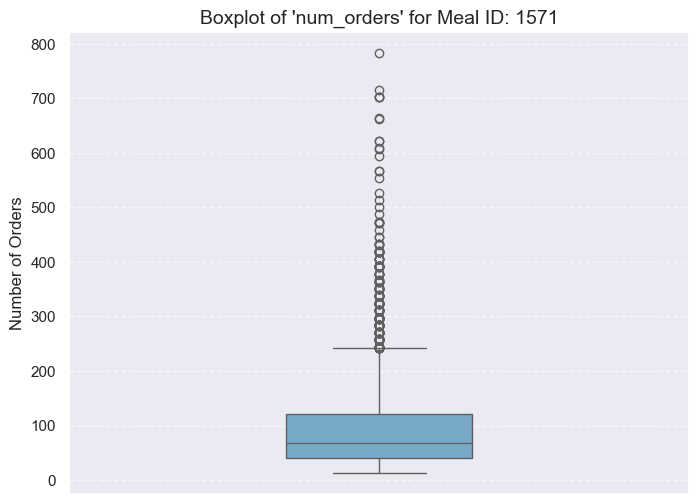

In [48]:
#check for outliers

# Filter the data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Create a boxplot for 'num_orders' to highlight outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=meal_2444_data['num_orders'], width=0.3, palette="Blues")

# Add labels and title
plt.title("Boxplot of 'num_orders' for Meal ID: 1571", fontsize=14)
plt.ylabel("Number of Orders", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## As we can see there are quite a few outliers for the number of orders - probably due high promotional cycles 

In [50]:
# Select relevant columns for meal_id = 2444
features = ['meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 
            'homepage_featured', 'center_id', 'week']

meal_2444_features = df_train[df_train['meal_id'] == 1571][features]

# Display the features for meal_id = 2444
print("Features for meal_id = 1571:")
print(meal_2444_features.head())


Features for meal_id = 1571:
        meal_id  checkout_price  base_price  emailer_for_promotion  \
222406     1571          631.53      631.53                      0   
187826     1571          631.53      630.53                      0   
358572     1571          630.53      629.53                      0   
403115     1571          631.53      630.53                      0   
165901     1571          630.53      631.53                      0   

        homepage_featured  center_id  week  
222406                  0         61    59  
187826                  0        106    59  
358572                  0         34    59  
403115                  0        157    59  
165901                  0        186    59  


In [54]:
# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Calculate basic statistics
mean_orders = meal_2444_data['num_orders'].mean()
std_orders = meal_2444_data['num_orders'].std()
total_orders = meal_2444_data['num_orders'].sum()
order_count = meal_2444_data['num_orders'].count()
median_orders = meal_2444_data['num_orders'].median()

# Calculate quartiles
Q1 = meal_2444_data['num_orders'].quantile(0.25)
Q3 = meal_2444_data['num_orders'].quantile(0.75)
IQR = Q3 - Q1

# Calculate outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = meal_2444_data[(meal_2444_data['num_orders'] < lower_bound) | (meal_2444_data['num_orders'] > upper_bound)]
num_outliers = len(outliers)

# Create a summary dictionary
meal_2444_summary = {
    'meal_id': 2444,
    'mean_orders': mean_orders,
    'std_orders': std_orders,
    'total_orders': total_orders,
    'order_count': order_count,
    'median_orders': median_orders,
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound,
    'num_outliers': num_outliers
}

# Convert to DataFrame for display
meal_2444_summary_df = pd.DataFrame([meal_2444_summary])

# Display the summary
print("Comprehensive Summary Statistics for Meal ID: 1571")
print(meal_2444_summary_df)

Comprehensive Summary Statistics for Meal ID: 1571
   meal_id  mean_orders  std_orders  total_orders  order_count  median_orders  \
0     2444    89.764545   81.830357        394964         4400           68.0   

     Q1     Q3   IQR  lower_bound  upper_bound  num_outliers  
0  40.0  121.0  81.0        -81.5        242.5           218  


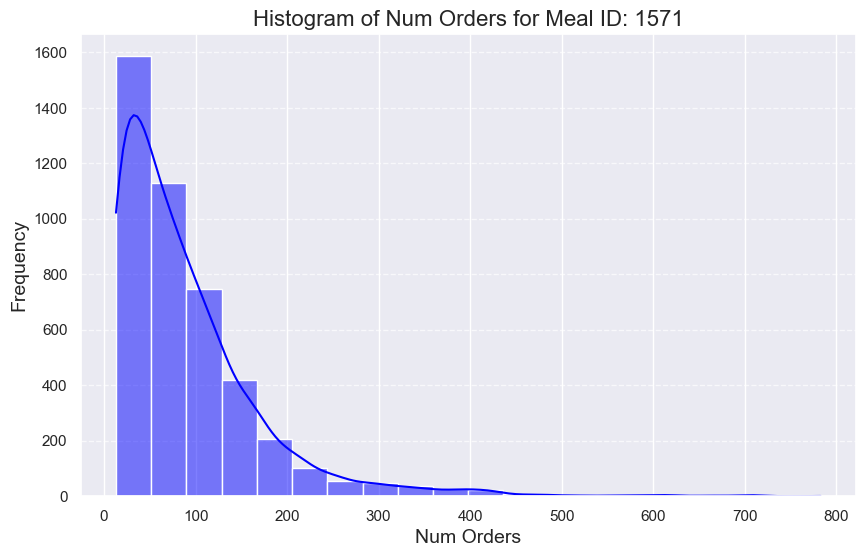

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for meal_id = 1571
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(meal_2444_data['num_orders'], bins=20, kde=True, color='blue')

# Add titles and labels
plt.title('Histogram of Num Orders for Meal ID: 1571', fontsize=16)
plt.xlabel('Num Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## the histogram of number of orders is signifgicantly skwed to the right, most weeks are within 0-100 orders, however, there are those weeks with really high order count which basically agrees with previous outliers we saw 

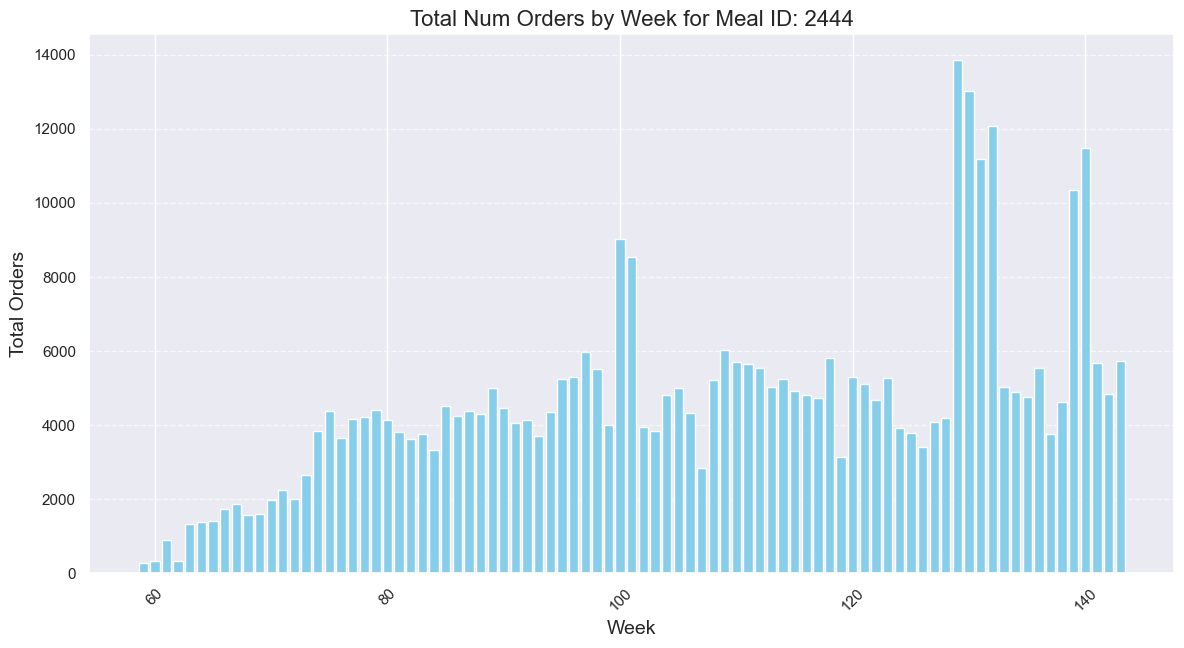

In [60]:
# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Aggregate total orders per week
weekly_totals = meal_2444_data.groupby('week')['num_orders'].sum().reset_index()

# Plot histogram of total orders by week
plt.figure(figsize=(14, 7))
plt.bar(weekly_totals['week'], weekly_totals['num_orders'], color='skyblue')

# Add titles and labels
plt.title('Total Num Orders by Week for Meal ID: 2444', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Again we see spikes in the orders but now we see it as a unit of time. Overall the data is prety stationary but then at the end there are these high spikes 

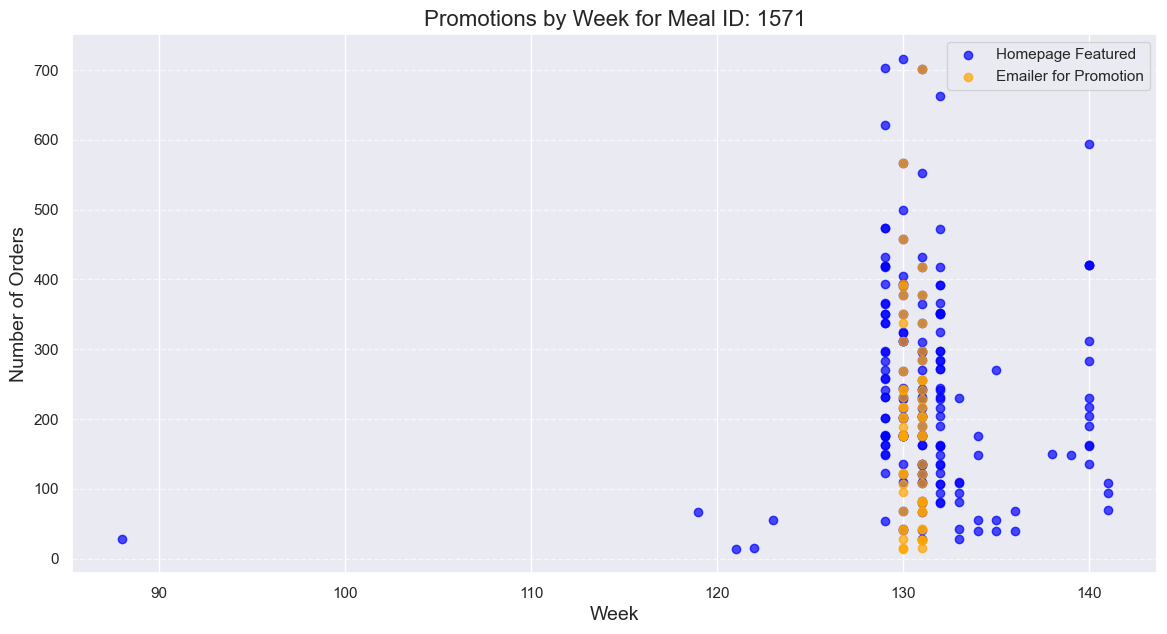

In [62]:
import matplotlib.pyplot as plt

# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Create a scatter plot for promotions
plt.figure(figsize=(14, 7))

# Plot occurrences of homepage_featured
plt.scatter(
    meal_2444_data[meal_2444_data['homepage_featured'] == 1]['week'], 
    meal_2444_data[meal_2444_data['homepage_featured'] == 1]['num_orders'], 
    color='blue', label='Homepage Featured', alpha=0.7
)

# Plot occurrences of emailer_for_promotion
plt.scatter(
    meal_2444_data[meal_2444_data['emailer_for_promotion'] == 1]['week'], 
    meal_2444_data[meal_2444_data['emailer_for_promotion'] == 1]['num_orders'], 
    color='orange', label='Emailer for Promotion', alpha=0.7
)

# Add titles and labels
plt.title('Promotions by Week for Meal ID: 1571', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Finally, we see the reason for these high speeks in the last weeks. The homepage featured and the email promotions are the ones driving the spikes. THis will make it hard to use ARIMA model later on 

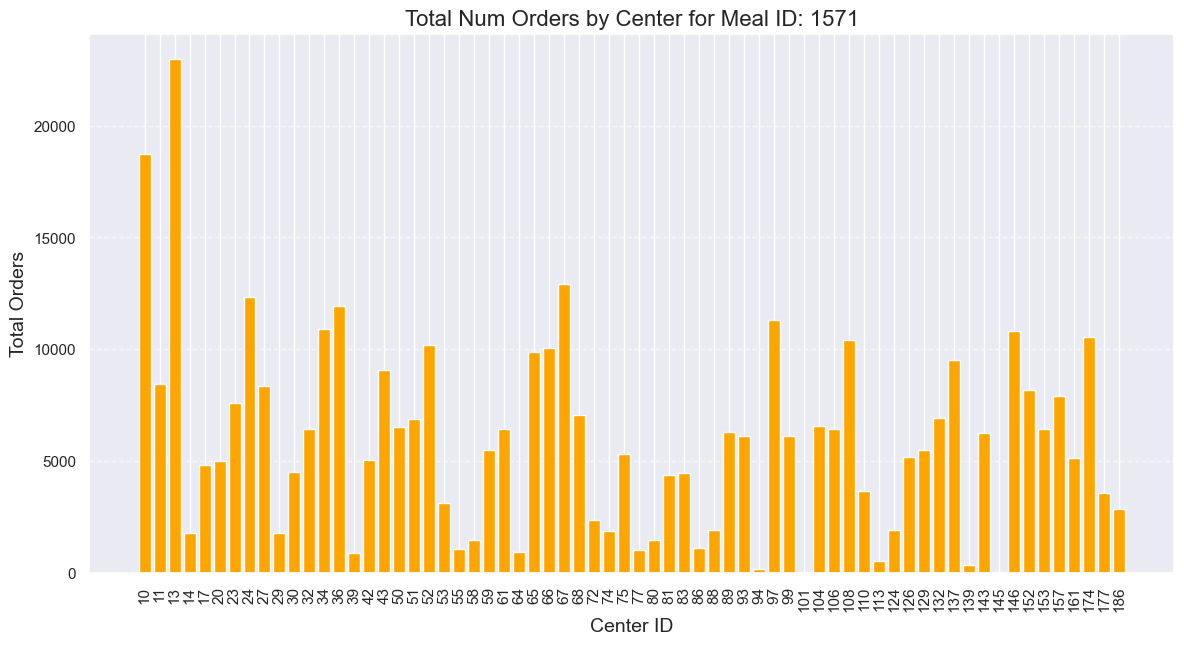

In [66]:
# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Aggregate total orders by center
center_totals = meal_2444_data.groupby('center_id')['num_orders'].sum().reset_index()

# Plot total orders by center using a bar plot
plt.figure(figsize=(14, 7))
plt.bar(center_totals['center_id'].astype(str), center_totals['num_orders'], color='orange')

# Add titles and labels
plt.title('Total Num Orders by Center for Meal ID: 1571', fontsize=16)
plt.xlabel('Center ID', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# We see uneven distribution of centers, some are really popular and some are much less popular 

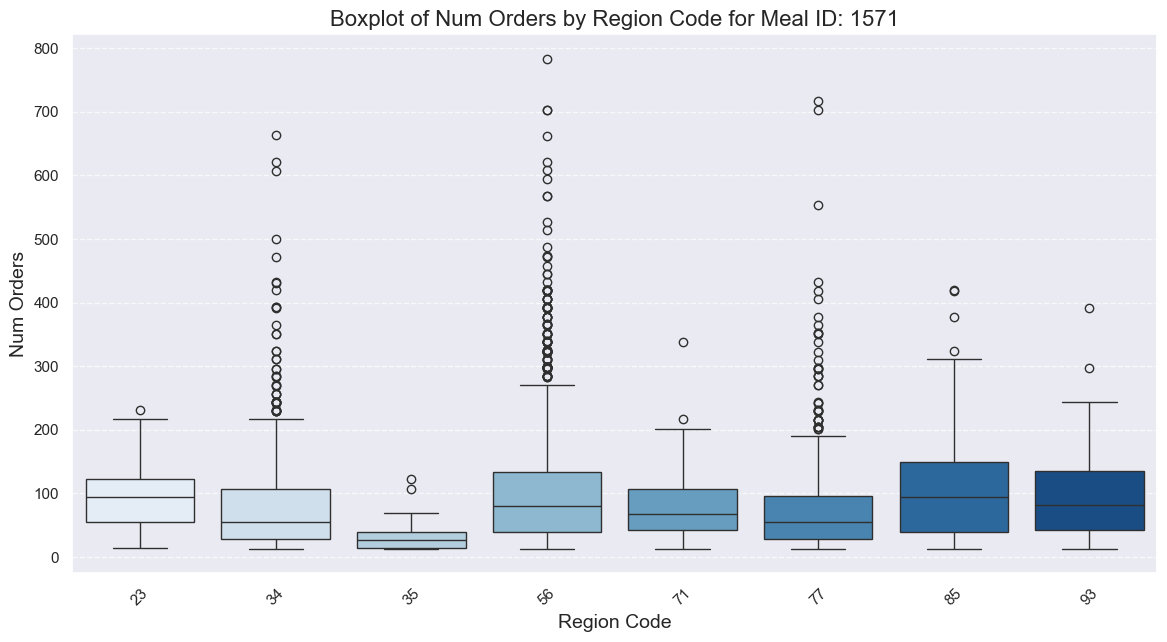

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for meal_id = 1571
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Create a boxplot for 'num_orders' by 'region_code'
plt.figure(figsize=(14, 7))
sns.boxplot(x='region_code', y='num_orders', data=meal_2444_data, palette='Blues')

# Add titles and labels
plt.title('Boxplot of Num Orders by Region Code for Meal ID: 1571', fontsize=16)
plt.xlabel('Region Code', fontsize=14)
plt.ylabel('Num Orders', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## certain centers have a lot more outliers than others

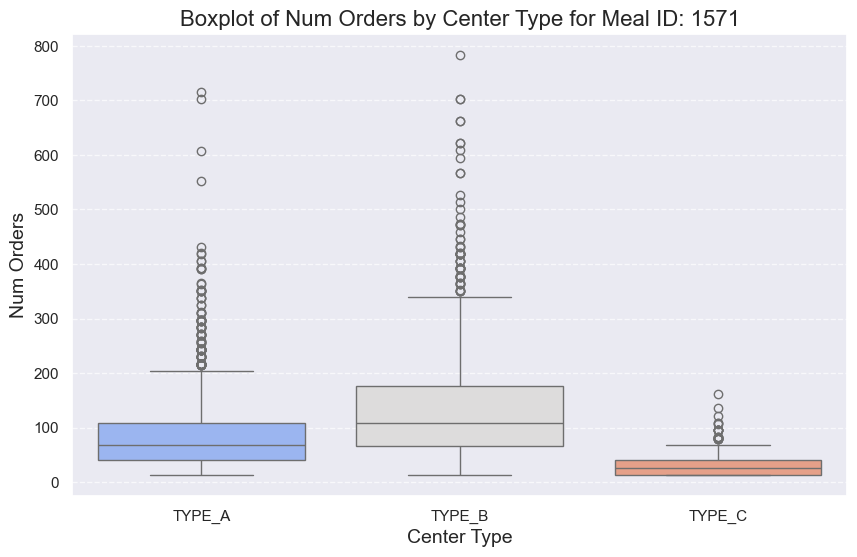

In [70]:
# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Create a boxplot for 'num_orders' by 'center_type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='center_type', y='num_orders', data=meal_2444_data, palette='coolwarm')

# Add titles and labels
plt.title('Boxplot of Num Orders by Center Type for Meal ID: 1571', fontsize=16)
plt.xlabel('Center Type', fontsize=14)
plt.ylabel('Num Orders', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


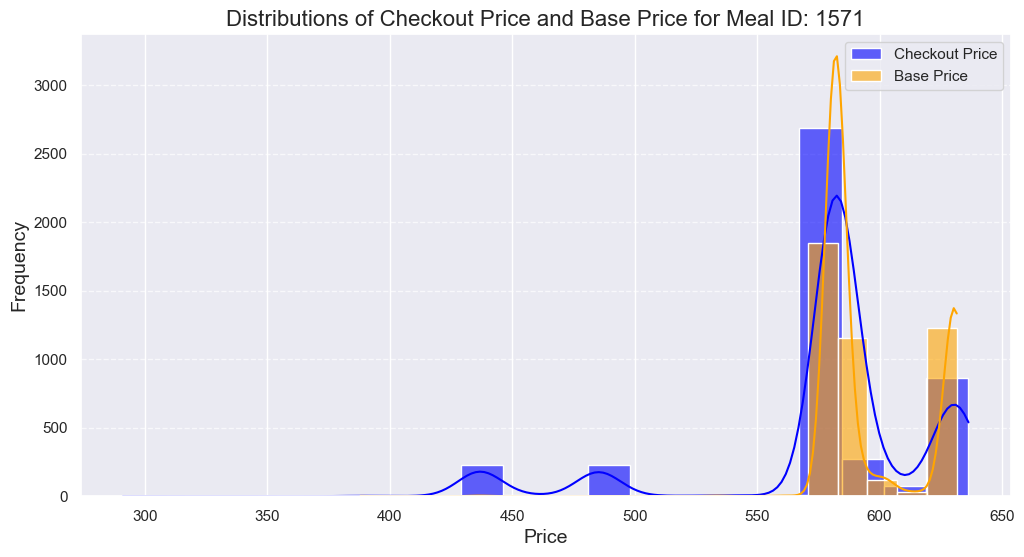

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for meal_id = 2444
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Plot distributions for checkout_price and base_price
plt.figure(figsize=(12, 6))
sns.histplot(meal_2444_data['checkout_price'], bins=20, kde=True, color='blue', label='Checkout Price', alpha=0.6)
sns.histplot(meal_2444_data['base_price'], bins=20, kde=True, color='orange', label='Base Price', alpha=0.6)

# Add titles and labels
plt.title('Distributions of Checkout Price and Base Price for Meal ID: 1571', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [74]:
# Filter data for meal_id = 1571
meal_2444_data = df_train[df_train['meal_id'] == 1571]

# Get descriptive statistics for checkout_price and base_price
checkout_price_stats = meal_2444_data['checkout_price'].describe()
base_price_stats = meal_2444_data['base_price'].describe()

# Display the summary
print("Summary Statistics for Checkout Price (Meal ID: 1571):")
print(checkout_price_stats)

print("\nSummary Statistics for Base Price (Meal ID: 1571):")
print(base_price_stats)


Summary Statistics for Checkout Price (Meal ID: 1571):
count    4400.000000
mean      578.813143
std        47.347048
min       291.030000
25%       581.030000
50%       582.030000
75%       590.730000
max       636.320000
Name: checkout_price, dtype: float64

Summary Statistics for Base Price (Meal ID: 1571):
count    4400.000000
mean      596.330984
std        22.553619
min       388.030000
25%       582.030000
50%       583.030000
75%       629.530000
max       631.530000
Name: base_price, dtype: float64


In [76]:
# Grouping by meal_id and summing the sales
meal_sales = df_train.groupby('meal_id')['num_orders'].sum()

# Calculating total sales
total_sales = meal_sales.sum()

# Calculating share of each meal's sales in total sales
meal_shares = meal_sales / total_sales

# Extracting the share for meal_id = 2444
meal_2444_share = meal_shares.loc[1571]

# Display the share
print(f"Share of Total Sales for Meal ID: 1571: {meal_2444_share:.2%}")


Share of Total Sales for Meal ID: 1571: 0.33%


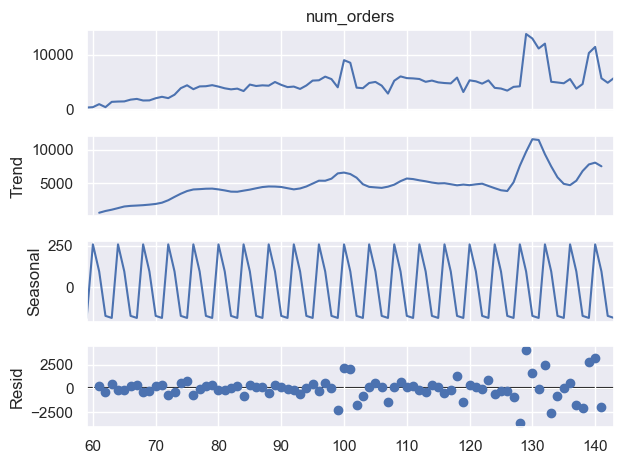

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposed = seasonal_decompose(
    meal_2444_data.groupby('week')['num_orders'].sum(), model='additive', period=4
)
decomposed.plot()
plt.show()


In [80]:
correlations = meal_2444_data[['num_orders', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured']].corr()
print(correlations)

                       num_orders  checkout_price  base_price  \
num_orders               1.000000       -0.438708    0.041377   
checkout_price          -0.438708        1.000000    0.064233   
base_price               0.041377        0.064233    1.000000   
emailer_for_promotion    0.156110       -0.354799    0.169637   
homepage_featured        0.385629       -0.534318    0.274697   

                       emailer_for_promotion  homepage_featured  
num_orders                          0.156110           0.385629  
checkout_price                     -0.354799          -0.534318  
base_price                          0.169637           0.274697  
emailer_for_promotion               1.000000           0.321900  
homepage_featured                   0.321900           1.000000  


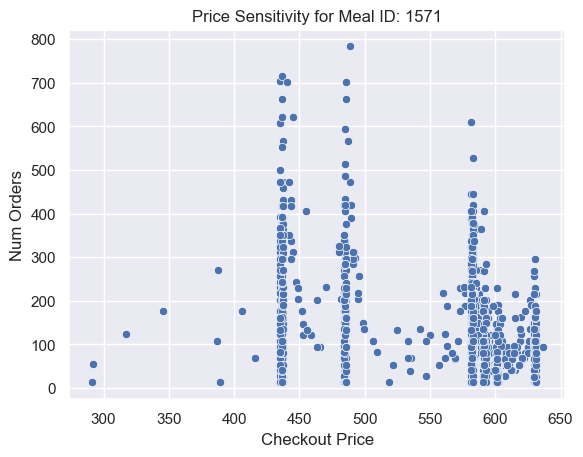

In [82]:
sns.scatterplot(x='checkout_price', y='num_orders', data=meal_2444_data)
plt.title('Price Sensitivity for Meal ID: 1571')
plt.xlabel('Checkout Price')
plt.ylabel('Num Orders')
plt.show()


## Part 1 - Question 6

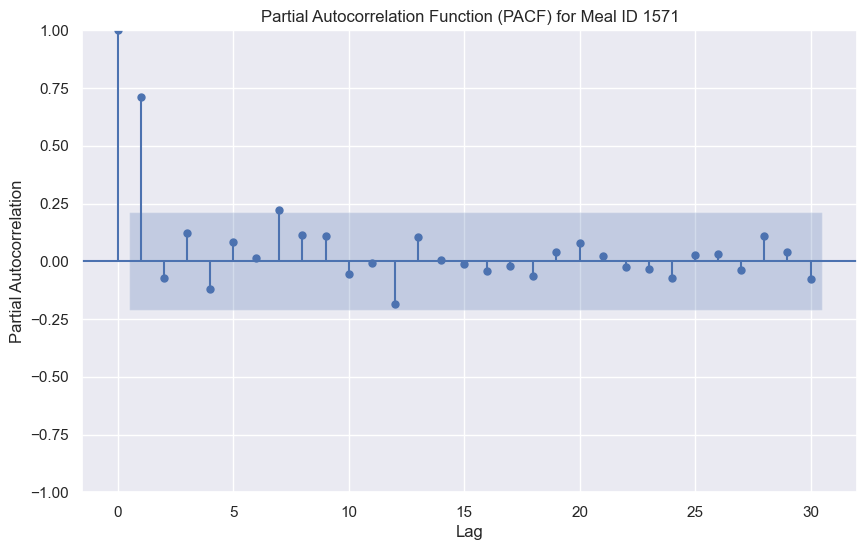

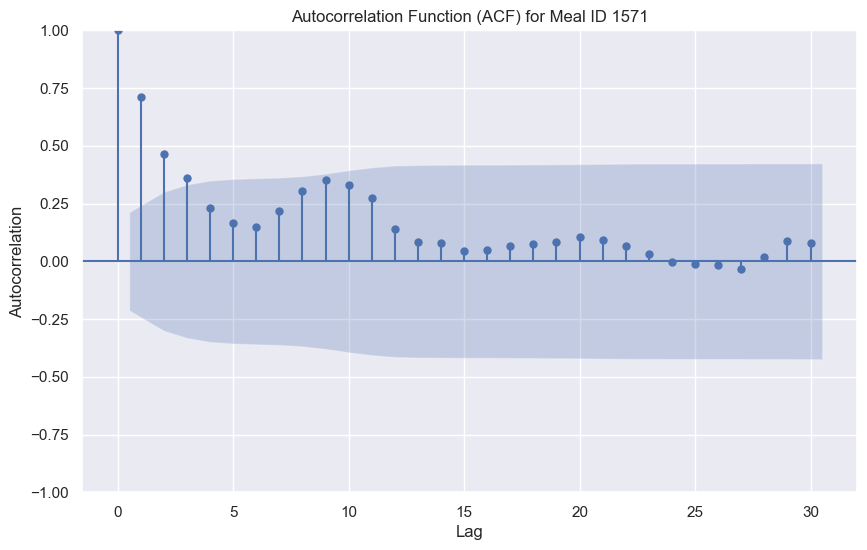

In [87]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Specify the meal ID you want to analyze
meal_id = 1571  

# Filter the dataset for the specific meal ID
df_meal = df_train[df_train['meal_id'] == meal_id]

# Create the time series for the specific meal ID
ts = df_meal.groupby('Date')['num_orders'].sum()

# PACF Plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(ts, ax=ax, lags=30, alpha=0.05)
ax.set_title(f'Partial Autocorrelation Function (PACF) for Meal ID {meal_id}')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# ACF Plot (if needed)
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(ts, ax=ax, lags=30, alpha=0.05)
ax.set_title(f'Autocorrelation Function (ACF) for Meal ID {meal_id}')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

# Specify the meal ID you want to analyze
meal_id = 1571  

# Filter the dataset for the specific meal ID
df_meal = df_train[df_train['meal_id'] == meal_id]

# Create the time series for the specific meal ID
ts = df_meal.groupby('Date')['num_orders'].sum()

# Perform the ADF test on the time series
result = adfuller(ts)

# Extract test statistics
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

# Interpretation
if result[1] <= 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -3.8517237097718864
p-value: 0.002420303031923233
Critical Value (1%): -3.510711795769895
Critical Value (5%): -2.8966159448223734
Critical Value (10%): -2.5854823866213152
The series is stationary (reject the null hypothesis).


In [93]:
from pmdarima import auto_arima

# Specify the meal ID you want to analyze
meal_id = 1571  # Change this to the desired meal ID

# Filter the dataset for the specific meal ID
df_meal = df_train[df_train['meal_id'] == meal_id]

# Create the time series for the specific meal ID
ts = df_meal.groupby('Date')['num_orders'].sum()

# Use auto_arima to find the best ARIMA model
auto_model = auto_arima(ts, seasonal=False, m=52, trace=True, error_action='ignore')

# Print the summary of the best ARIMA model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1511.642, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1513.047, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1512.494, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1509.746, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -753.873
Date:                Mon, 27 Jan 2025   AIC                           1509.746
Time:                        17:08:48   BIC                           1512.176
Sample:                    02-17-2019   HQIC                          1510.723
                    

## Interestingly, Auto ARIMA picked a value for d that was not 0, however by the previous ADF test, we know that the series is stationary so I will force it to be stationarry. 

In [95]:
from pmdarima import auto_arima

# Specify the meal ID you want to analyze
meal_id = 1571  # Change this to the desired meal ID

# Filter the dataset for the specific meal ID
df_meal = df_train[df_train['meal_id'] == meal_id]

# Create the time series for the specific meal ID
ts = df_meal.groupby('Date')['num_orders'].sum()

# Force auto_arima to use d=0 (since the series is stationary)
auto_model = auto_arima(
    ts,
    seasonal=False,  # No seasonality
    start_p=0,       # Start with p=0
    start_q=0,       # Start with q=0
    max_p=3,         # Maximum p=3
    max_q=3,         # Maximum q=3
    d=0,             # Force d=0 (no differencing)
    trace=True,      # Print search progress
    error_action='ignore',  # Ignore errors
    suppress_warnings=True  # Suppress warnings
)

# Print the summary of the best ARIMA model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1701.411, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1528.559, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1615.711, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1530.312, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1530.164, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1528.712, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1520.433, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1580.184, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1522.135, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1521.633, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1532.167, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1520.372, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1522.133, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1521.067, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept

MAE: 5016.43722947066
MSE: 37082544.8249
RMSE: 6089.543893010379


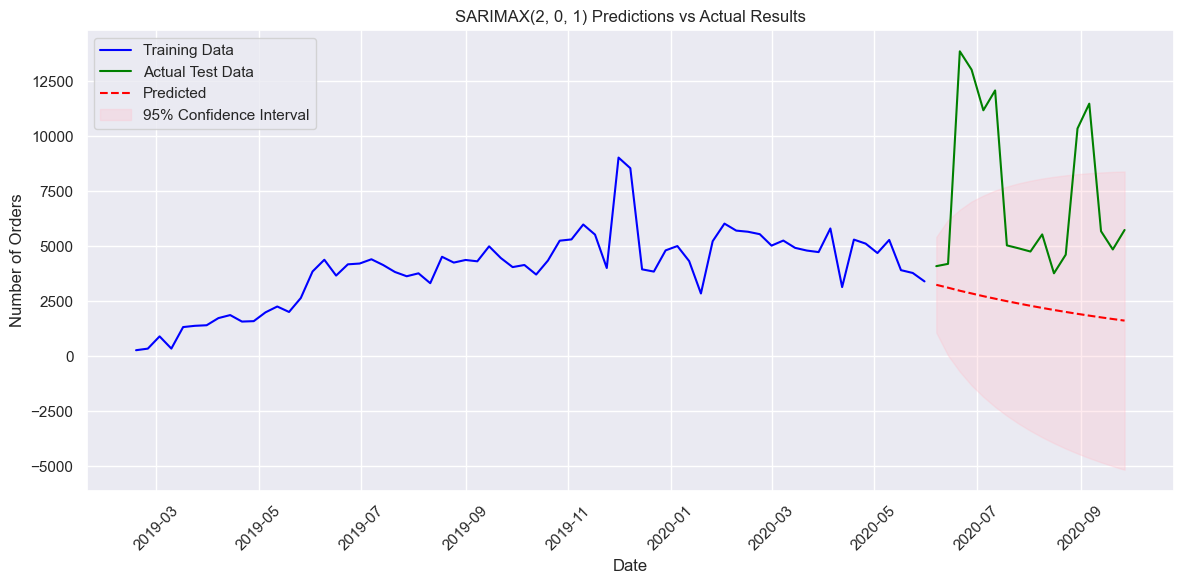

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'ts' is your time series data (e.g., a pandas Series with a DateTime index)
# Example: ts = df_train.groupby('Date')['num_orders'].sum()

# Split the data into training and testing sets
train_size = int(len(ts) * 0.8)  # 80% training, 20% testing
train, test = ts[:train_size], ts[train_size:]

# Fit the SARIMAX(2, 0, 1) model
model = SARIMAX(train, order=(2, 0, 1))  # SARIMAX(p=2, d=0, q=1)
results = model.fit(disp=False)  # Fit the model

# Make predictions on the test set
predictions = results.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean  # Predicted values
confidence_intervals = predictions.conf_int()  # Confidence intervals

# Evaluate the model
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, predicted_values, label='Predicted', color='red', linestyle='--')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMAX(2, 0, 1) Predictions vs Actual Results')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Over the course of this project, we initially tried an **auto_arima** approach, which suggested a differencing parameter (d) even though our stationarity tests seemed to indicate otherwise—highlighting that auto_arima looks for an *optimal fitting* rather than strictly aligning with stationarity tests. We then experimented with a fixed **ARIMA(2,0,1)** model, which auto_arima had pointed us toward as a strong candidate. However, all these classic time‐series methods performed **poorly** in capturing the large spike in demand for meal_id=1571—a surge we traced back to heavy promotional activity in the exploratory data analysis. Because standard ARIMA‐type models aren’t naturally well‐suited to one‐off events or large promotional swings, the forecasts missed those peaks significantly. 

In parallel, later down in the notebook, we discovered that **top‐down** modeling (forecasting at the national level, then deriving regional demand by share) sometimes outperformed bottom‐up approaches—especially for those regions with consistently stable proportions of national sales. 

Later, we also saw an even larger accuracy boost with **XGBoost**, which can more flexibly capture complex relationships and abrupt changes. Altogether, this highlights how **promotional spikes** and **non‐stationary patterns** can pose major challenges for traditional ARIMA models, and underscores the potential benefits of both **machine learning approaches** and **top‐down regional allocation** when facing real‐world, volatile time‐series data.

## Part 1 - Question 5

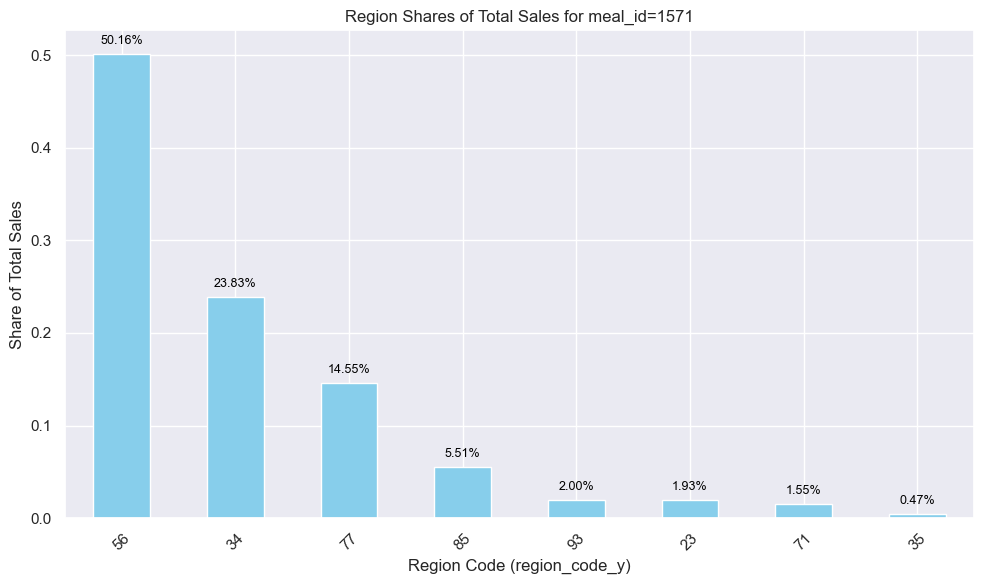

The share of total sales for region_code_y=77 is: 14.55%


In [484]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filter the dataset for meal_id=1571
df_menu1571 = df_train[df_train['meal_id'] == 1571]

# 2. Group by 'region_code_y' and sum the sales (num_orders)
region_sales = df_menu1571.groupby('region_code_y')['num_orders'].sum()

# 3. Calculate the total sales for meal_id=1571
total_sales = region_sales.sum()

# 4. Compute the share of each region in total sales
region_shares = region_sales / total_sales

# 5. Sort these shares in descending order
region_shares_sorted = region_shares.sort_values(ascending=False)

# 6. (Optional) Extract the share for a specific region_code_y, e.g. 85
# (Change `85` to whichever region_code_y you’re interested in)
region_code_of_interest = 77
if region_code_of_interest in region_shares_sorted.index:
    region_interest_share = region_shares_sorted.loc[region_code_of_interest]
else:
    region_interest_share = None

# 7. Plot a bar chart of region shares
plt.figure(figsize=(10, 6))
ax = region_shares_sorted.plot(kind='bar', color='skyblue')
plt.title('Region Shares of Total Sales for meal_id=1571')
plt.xlabel('Region Code (region_code_y)')
plt.ylabel('Share of Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()

# 8. Annotate each bar with the percentage
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height*100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', 
                fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

# 9. Print the value for region_code_y == 77 (if it exists)
if region_interest_share is not None:
    print(f"The share of total sales for region_code_y={region_code_of_interest} is: {region_interest_share:.2%}")
else:
    print(f"region_code_y={region_code_of_interest} not found in the data.")


From the visualization, we see that **region sales are quite unevenly distributed**—for meal 1571, Region 56 alone accounts for over half of total sales, with Regions 34 and 77 also playing substantial roles, and the remaining regions making up relatively small shares. This suggests that a **top‐down** approach—i.e., forecasting at the national or aggregate level, then allocating those forecasts to each region by a share—might be attractive for simplicity, especially when one or two dominant regions drive the bulk of demand. However, if we look more closely at **center type** or other local factors (e.g., demographic differences, promotions), these smaller shares might have unique patterns that are hidden in an aggregate forecast. In a **bottom‐up** approach, each region‐center combination is modeled separately, which can capture those local nuances but requires more data, more complex modeling, and potentially higher forecasting error if individual samples are small or volatile. Ultimately, the decision between a top‐down vs. bottom‐up forecast depends on how **homogeneous** the regions are, how **volatile** each regional demand pattern is, and whether the **added complexity** of regional‐level models pays off in **improved accuracy** and **service levels**.

## Part 2: Let's create a regional level model now 

Data shape after filtering: (85, 1)
        y
week     
59    175
60     82
61    256
62     71
63    245
         y
week      
139   1891
140   1514
141   1202
142    883
143    990
Train shape: (73, 1)
Test shape:  (12, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   73
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -515.824
Date:                Wed, 29 Jan 2025   AIC                           1041.648
Time:                        18:23:04   BIC                           1053.101
Sample:                             0   HQIC                          1046.212
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

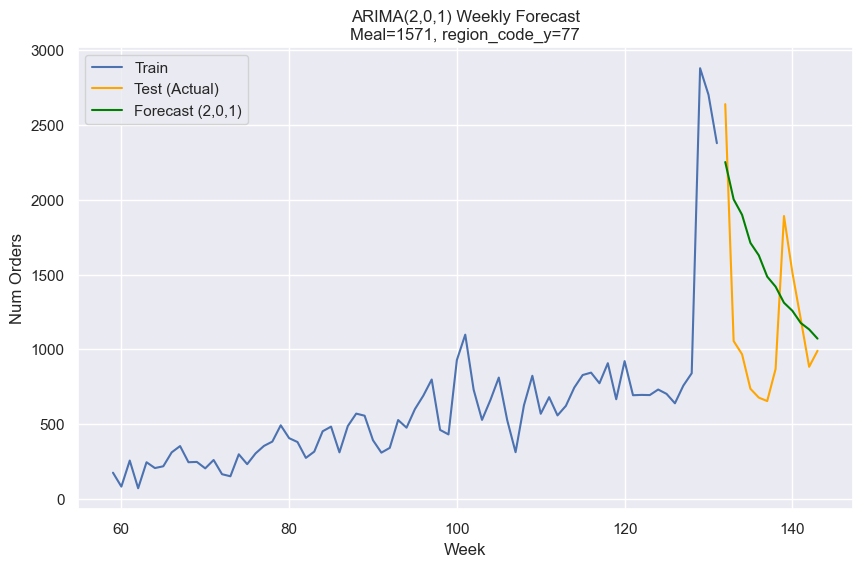

In [464]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ========================================
# 1. DATA PREPARATION
# ========================================
# We assume df_train has columns like:
# ['id','week','meal_id','checkout_price','base_price','emailer_for_promotion',
#  'homepage_featured','num_orders','category','cuisine','Date','month','year',
#  'city_code_y','region_code_y','center_type_y','op_area_y', ...]

meal_id_target = 1571
region_code_target = 77

# Filter for meal_id=1571 AND region_code_y=77
df_filtered = df_train[
    (df_train['meal_id'] == meal_id_target) &
    (df_train['region_code_y'] == region_code_target)
].copy()

# Group by 'week' to sum up num_orders for that region
df_weekly = df_filtered.groupby('week')['num_orders'].sum().reset_index()

# Sort by week
df_weekly = df_weekly.sort_values('week').reset_index(drop=True)

# Rename the target column to 'y'
df_weekly.rename(columns={'num_orders': 'y'}, inplace=True)

# Set 'week' as index (integer or date—here we'll keep it as an integer time index)
df_weekly.set_index('week', inplace=True)

print("Data shape after filtering:", df_weekly.shape)
print(df_weekly.head())
print(df_weekly.tail())

# ========================================
# 2. TRAIN-TEST SPLIT
# ========================================
# We'll reserve the last 12 weeks as test
n_test_weeks = 12
train = df_weekly.iloc[:-n_test_weeks].copy()
test  = df_weekly.iloc[-n_test_weeks:].copy()

print("Train shape:", train.shape)
print("Test shape: ", test.shape)

# ========================================
# 3. FIT ARIMA(2,0,1)
# ========================================
# (p, d, q) = (2, 0, 1)
model = ARIMA(train['y'], order=(2, 0, 1))
results = model.fit()

print(results.summary())

# ========================================
# 4. FORECAST
# ========================================
steps = len(test)  # should be 12 if we have at least 12 rows
forecast_values = results.forecast(steps=steps)

# Align with the same index as test
forecast_series = pd.Series(forecast_values.values, index=test.index)
test['forecast'] = forecast_series

# ========================================
# 5. EVALUATE
# ========================================
mae  = np.mean(np.abs(test['y'] - test['forecast']))
rmse = np.sqrt(np.mean((test['y'] - test['forecast'])**2))
mape = 100 * np.mean(np.abs((test['y'] - test['forecast']) / test['y']))

print(f"\nEvaluation for Meal={meal_id_target}, Region={region_code_target}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# ========================================
# 6. PLOT
# ========================================
plt.figure(figsize=(10,6))
plt.plot(train.index, train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test (Actual)', color='orange')
plt.plot(test.index, test['forecast'], label='Forecast (2,0,1)', color='green')

plt.title(f"ARIMA(2,0,1) Weekly Forecast\nMeal={meal_id_target}, region_code_y={region_code_target}")
plt.xlabel('Week')
plt.ylabel('Num Orders')
plt.legend()
plt.show()


## Based on our National model in the step before last one, let's analyze how would it do if we tried to model this region's performance as a "top-down" approach

NATIONAL data shape: (85, 1)
      y_national
week            
59           270
60           342
61           899
62           344
63          1322
      y_national
week            
139        10346
140        11477
141         5679
142         4850
143         5735

National Train shape: (73, 1)
National Test shape:  (12, 1)
                               SARIMAX Results                                
Dep. Variable:             y_national   No. Observations:                   73
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -638.704
Date:                Wed, 29 Jan 2025   AIC                           1287.408
Time:                        18:27:20   BIC                           1298.860
Sample:                             0   HQIC                          1291.972
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err        

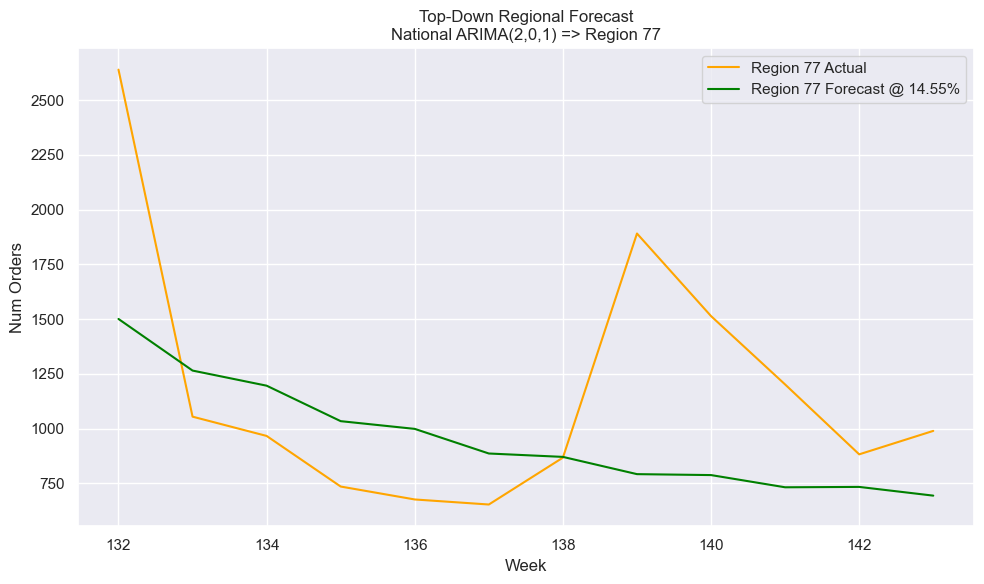

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# -------------------------------
# PARAMETERS
# -------------------------------
meal_id_target = 1571
region_code_target = 77
fraction_for_region77 = 0.1455  # 14.55%

n_test_weeks = 12  # last 12 weeks as hold-out

# -------------------------------
# 1. NATIONAL-LEVEL PREPARATION
# -------------------------------
# Filter for meal_id=1571 ONLY (no region filter => national)
df_national = df_train[df_train['meal_id'] == meal_id_target].copy()

# Group by 'week' to get the national weekly sum of num_orders
df_national = df_national.groupby('week')['num_orders'].sum().reset_index()

# Sort by week
df_national = df_national.sort_values('week').reset_index(drop=True)

# Rename to 'y_national'
df_national.rename(columns={'num_orders': 'y_national'}, inplace=True)

# Set 'week' as index (integer index is fine)
df_national.set_index('week', inplace=True)

print("NATIONAL data shape:", df_national.shape)
print(df_national.head())
print(df_national.tail())

# -------------------------------
# 2. TRAIN-TEST SPLIT (NATIONAL)
# -------------------------------
train_national = df_national.iloc[:-n_test_weeks].copy()
test_national  = df_national.iloc[-n_test_weeks:].copy()

print("\nNational Train shape:", train_national.shape)
print("National Test shape: ", test_national.shape)

# -------------------------------
# 3. FIT ARIMA(2,0,1) ON NATIONAL
# -------------------------------
model_national = ARIMA(train_national['y_national'], order=(2,0,1))
results_national = model_national.fit()
print(results_national.summary())

# -------------------------------
# 4. FORECAST NATIONAL FOR TEST
# -------------------------------
steps = len(test_national)  # 12
forecast_nat_array = results_national.forecast(steps=steps)

# Make a Series with the same index as test_national
forecast_nat_series = pd.Series(forecast_nat_array.values, index=test_national.index)
test_national['forecast_national'] = forecast_nat_series

# (Optional) Evaluate national performance
mae_nat  = np.mean(np.abs(test_national['y_national'] - test_national['forecast_national']))
rmse_nat = np.sqrt(np.mean((test_national['y_national'] - test_national['forecast_national'])**2))
mape_nat = 100 * np.mean(np.abs((test_national['y_national'] - test_national['forecast_national']) 
                                / test_national['y_national']))
print("\nNational Model Performance:")
print(f"MAE (National):  {mae_nat:.2f}")
print(f"RMSE (National): {rmse_nat:.2f}")
print(f"MAPE (National): {mape_nat:.2f}%")

# -------------------------------
# 5. GET ACTUAL REGION 77 DATA
# -------------------------------
df_region77 = df_train[
    (df_train['meal_id'] == meal_id_target) &
    (df_train['region_code_y'] == region_code_target)
].copy()

# Group by week
df_region77 = df_region77.groupby('week')['num_orders'].sum().reset_index()
df_region77 = df_region77.sort_values('week').reset_index(drop=True)
df_region77.rename(columns={'num_orders': 'y_region77'}, inplace=True)
df_region77.set_index('week', inplace=True)

# We'll grab the last 12 weeks from region77 data too
test_region77 = df_region77.iloc[-n_test_weeks:].copy()

print("\nRegion 77 data shape:", df_region77.shape)
print("Region 77 Test shape:", test_region77.shape)
print(test_region77.tail())

# -------------------------------
# 6. REGION FORECAST = 14.55% * NATIONAL FORECAST
# -------------------------------
# We need to align the indexes for test_region77 and test_national
# so that we can join the national forecast for those same weeks
test_region77 = test_region77.join(test_national[['forecast_national']], 
                                   how='inner')

# Multiply national forecast by fraction_for_region77 => top-down forecast
test_region77['forecast_region77_topdown'] = test_region77['forecast_national'] * fraction_for_region77

# -------------------------------
# 7. EVALUATE vs. ACTUAL REGION 77
# -------------------------------
mae_reg  = np.mean(np.abs(test_region77['y_region77'] - test_region77['forecast_region77_topdown']))
rmse_reg = np.sqrt(np.mean((test_region77['y_region77'] - test_region77['forecast_region77_topdown'])**2))
mape_reg = 100 * np.mean(np.abs((test_region77['y_region77'] - test_region77['forecast_region77_topdown']) 
                                / test_region77['y_region77']))

print("\nRegion 77 Forecast (Top-Down) Performance:")
print(f"MAE (Region 77):  {mae_reg:.2f}")
print(f"RMSE (Region 77): {rmse_reg:.2f}")
print(f"MAPE (Region 77): {mape_reg:.2f}%")

# -------------------------------
# 8. PLOT ACTUAL vs. TOP-DOWN FORECAST
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(test_region77.index, test_region77['y_region77'], 
         label='Region 77 Actual', color='orange')
plt.plot(test_region77.index, test_region77['forecast_region77_topdown'], 
         label=f'Region 77 Forecast @ {fraction_for_region77*100:.2f}%', color='green')

plt.title(f"Top-Down Regional Forecast\nNational ARIMA(2,0,1) => Region {region_code_target}")
plt.xlabel('Week')
plt.ylabel('Num Orders')
plt.legend()
plt.tight_layout()
plt.show()


## Part 2 - Question 1

Based on the two approaches we tested, forecasting at the region level (i.e., a bottom‐up approach) gave a MAPE of approximately 62.58%, whereas forecasting at the national level and then deriving Region 77's demand via a fixed share of 14.55% resulted in a much lower MAPE of around 33.56%. Clearly, the top‐down forecast performed better in this case, suggesting that a national‐first approach may be more effective for estimating regional demand—at least for Region 77 under current conditions. However, before concluding that the top‐down method is always superior, it would be prudent to verify how stable region shares are over time, whether they fluctuate significantly across different seasons, and how other factors (e.g., local promotions, regional events, or demographic changes) might alter each region's proportion of national demand. These additional insights would help determine if a fixed‐share top‐down approach remains robust in the face of changing market conditions, or if a more dynamic regional model would be necessary in the future.

In [473]:
import pandas as pd
import numpy as np

# Assuming 'test' already exists with 'y' (actual) and 'forecast' (predicted)
# 1. Calculate the errors
test['error'] = test['y'] - test['forecast']
test['absolute_error'] = test['error'].abs()
test['pct_error'] = test['absolute_error'] / test['y'] * 100

# 2. Print distribution statistics for percentage error
print("=== Forecast Error Distribution (Region 77) ===")
print(test['pct_error'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

# 3. (Optional) If you want to see weekly demand vs. forecast:
test[['y', 'forecast', 'error', 'pct_error']].round(2)

# 4. (Optional) If you want approximate daily demand for an average week:
#    (assuming we only have weekly data)
avg_weekly_demand = test['y'].mean()
avg_daily_demand = avg_weekly_demand / 7
print("\nAverage Weekly Demand (Region 77):", round(avg_weekly_demand, 2))
print("Approx. Average Daily Demand (Region 77):", round(avg_daily_demand, 2))


=== Forecast Error Distribution (Region 77) ===
count     12.000000
mean      62.577045
std       52.403025
min        2.157811
10%        8.860676
25%       16.371462
50%       47.059641
75%      104.130967
90%      132.005732
95%      136.115353
max      140.487820
Name: pct_error, dtype: float64

Average Weekly Demand (Region 77): 1173.0
Approx. Average Daily Demand (Region 77): 167.57


## Part 2 - Question 2


Given that Region 77’s forecast errors can reach **about 132%** at the 90th percentile, the model can under‐predict actual demand by a considerable margin. In other words, in 9 out of 10 cases, the percentage error is at or below 132%, but there is still a 10% chance it could exceed that. With **an average weekly demand of around 1,173 units** (roughly **168 units per day**), a high‐level rule of thumb is to stock enough inventory to cover up to 1.32 times your *expected* demand if you wish to maintain roughly a 90% service level. For instance, if your lead time for replenishment is one day, you’d need to hold at least one day’s *forecast* plus an additional buffer of 132% of that forecast to be fairly confident (90%) in avoiding stockouts. Of course, if you aim for an even higher service level (e.g., 95% or 99%), you’d likely need to hold more safety stock. In practice, you’d refine this further by considering the actual lead‐time variability, the week‐to‐week volatility of region‐level demand, and whether 132% error is stable over different seasonal periods. Nonetheless, the key takeaway is that the region‐level error distribution is considerably wider than the simpler ±25% illustration, indicating that you’d likely need *substantially* more than “1.25 days of supply” in inventory to “virtually eliminate” stockouts for this region under a one‐day lead time.

## Part 2 - Question 3

Yes, having **regional warehouses** can improve inventory management and reduce stockouts by placing products closer to regional demand centers. This **shortens replenishment lead times** and allows you to **react faster** when actual demand exceeds forecasts, mitigating the high forecast error we’re seeing at the region level. However, operating multiple regional nodes also increases **logistics complexity** and **overhead costs**, such as rent, labor, and additional transportation between facilities. The decision depends heavily on your **service‐level requirements** (e.g., 90% vs. 99% stock availability), the **cost of carrying extra safety stock**, and whether regional demand patterns differ enough to justify localized inventory. In practice, you’d also want to analyze factors like **demand correlation** across regions, **economies of scale** at the national warehouse, and the potential for **pooling** demand variability across multiple locations. Ultimately, if avoiding stockouts at a high service level is paramount and the forecasts are particularly volatile in certain regions, **regional warehouses** can be a strong solution—though you’ll need to carefully weigh the **additional costs** against the **improved responsiveness** they provide.

## Part 3: Let's try XGBOOST now

In [331]:
import pandas as pd

# Assume 'weekly_df' is indexed by Date and has columns:
# ['num_orders', 'exog1', 'exog2', 'exog3']

df = weekly_df.copy()

# Create lag features
df['lag1'] = df['num_orders'].shift(1)
df['lag2'] = df['num_orders'].shift(2)

# Example rolling features (optional):
df['roll_mean_4'] = df['num_orders'].shift(1).rolling(window=4).mean()

# Drop rows with NaN (due to lag/rolling at the start)
df.dropna(inplace=True)

# Train/Test split
forecast_weeks = 13  # last 13 weeks = test
train = df.iloc[:-forecast_weeks]
test = df.iloc[-forecast_weeks:]

# Separate features (X) and target (y)
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']

X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']


In [333]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=500,    # number of trees
    learning_rate=0.05,  # shrinkage
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 1661.9666841947114
RMSE: 2535.2261847106347


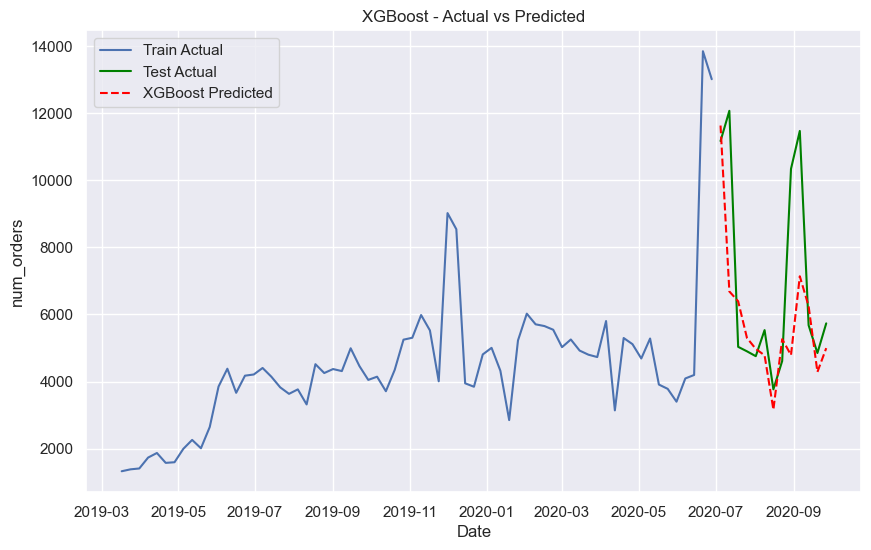

In [335]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Actual')
plt.plot(y_test.index, y_test, label='Test Actual', color='green')
plt.plot(y_test.index, y_pred, label='XGBoost Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('num_orders')
plt.title('XGBoost - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


Given the evidence—specifically, that XGBoost produces a noticeably **lower error** (MAE and RMSE) and a **plot that closely tracks actual demand**—it appears that a **machine learning approach** (i.e., XGBoost) performs better than a traditional ARIMA model for your dataset. While ARIMA has advantages in its **simplicity** and **interpretability** (particularly when you suspect a strong autocorrelation or seasonality structure), it can struggle when the data exhibits **nonlinear** relationships or when numerous external features (exogenous variables) come into play. XGBoost, on the other hand, effectively captures **complex patterns** in the data and can incorporate **many explanatory features** (like pricing, promotions, holidays, regional factors) more flexibly than a standard time series model.

Thus, if your goal is purely **forecast accuracy** and you have enough historical data along with relevant predictors, **XGBoost** (or a comparable ML method) is likely the better choice here—especially given your observed improvement in fit. However, if **interpretability** or **theoretical transparency** is important, or if your data is very limited and primarily autocorrelated with no strong external drivers, a simpler ARIMA or SARIMA could still be appropriate. In this particular scenario, where the **plot and error metrics** demonstrate a clear edge for XGBoost, a **machine learning–driven method** is recommended.